# Pseudolabels analysis for *Escherichia coli* data

This notebook provides a preliminary analysis for pseudolabels determined for the 54 *E. coli* samples to be used for GraSSPlas project. 

## Obtaining pseudolabels

In this analysis, we focus on two types of pseudolabels: plasmid and chromosome. Plasmid labels were obtained by mapping short read contigs against known plasmid gene databases. Chromosome databases on the other hand were obtained based on contig length and read depth thresholds. 

The databases required for plasmid pseudolabels were obtained manually by following the instructions on https://github.com/phac-nml/mob-suite on 14/05/2024. From the downloaded zipped file, we use four FASTA files. Each file contains a set of genes or proteins found in plasmids. The gene databases include replicon DNA sequences (rep.dna.fas) and origin of transfer DNA sequences (orit.dna.fas). The protein databases include the mobility proteins (mob.proteins.faa) and mate-pair formation proteins (mpf.proteins.faa). We use the Basic Local Alignment Search Tool (BLAST) to map the genes or proteins from these databases onto the short read contigs. If the contig is at least 500 bp and the quality of the mapping between the gene / protein and contig is high enough (0.8), the contig is assigned the label plasmid.

To assign the chromosome label, the mean ($m$) and standard deviation ($sd$) of normalized read depths is obtained from the sample GFA files. If the contig has a length of at least 200000 bp and a read depth of at *most*  $m+2sd$, the contig is labelled a chromosome.

In [74]:
import os
import pandas as pd
import networkx as nx
import statistics as stat
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [78]:
PLSNESS_DIR = '../data/plasmidness'
LABELS_DIR = '../data/pseudolabels'


In [85]:
labels_dict = {}
pls_labels_set = set()
chr_labels_set = set()
for sample in os.listdir(LABELS_DIR):
    sample_df = pd.read_csv(LABELS_DIR+'/'+sample+'/pseudolabels.tsv', sep='\t')
    
    pls_ctgs = sample_df['plasmid'].sum()
    chr_ctgs = sample_df['chromosome'].sum()
    labels_dict[sample] = {'plasmids': pls_ctgs, 'chromosomes': chr_ctgs}
    
    for index, row in sample_df.iterrows():
        if row['plasmid'] == 1:
            pls_labels_set.add(sample + '_' + str(row['contig']))
        if row['chromosome'] == 1:
            chr_labels_set.add(sample + '_' + str(row['contig']))
labels_df = pd.DataFrame.from_dict(labels_dict).T

In [92]:
pls_labels = {}
mappings = ['matepair', 'mobility', 'origintransfer', 'replicon'] 
for sample in os.listdir(PLSNESS_DIR):
    for mapping in mappings:
        mapping_file = PLSNESS_DIR+'/'+sample+'/'+mapping+'_mapping.tsv'
        if os.path.getsize(mapping_file) > 0:
            mapping_df = pd.read_csv(mapping_file, sep='\t',header=None)
            for index, row in mapping_df.iterrows():
                sample_ctg_id, ctg_len = sample+'_'+str(row[0]), int(row[3])
                if sample_ctg_id not in pls_labels:
                    pls_labels[sample_ctg_id] = {'length': 0, 'matepair': 0, 
                                                 'mobility': 0, 'origintransfer': 0, 'replicon': 0}
                pls_labels[sample_ctg_id]['length'] = ctg_len
                pls_labels[sample_ctg_id][mapping] = 1
pls_labels_df = pd.DataFrame.from_dict(pls_labels).T

In [93]:
pls_labels_df

,length,matepair,mobility,origintransfer,replicon
EC_E13DN_1_E_35,38992,1,1,1,1
EC_E13DN_1_E_38,23307,0,0,0,1
EC_E13DN_1_E_48,12343,0,0,0,1
EC_0038_3S2_D_19,89983,1,1,1,1
EC_0038_3S2_D_38,6995,0,1,1,1
...,...,...,...,...,...
EC_0012_C1_H_77,5569,0,1,1,1
EC_0012_C1_H_100,2089,0,0,0,1
EC_0012_C1_H_99,2235,0,0,0,1
EC_4957_C1_H_21,79861,1,1,1,1


In [94]:
min_len = pls_labels_df['length'].min()
max_len = pls_labels_df['length'].max()
mean_len = pls_labels_df['length'].mean()
print("Minimum length of plasmid labelled contig: ", min_len)
print("Maximum length of plasmid labelled contig: ", max_len)
print("Average length of plasmid labelled contig: ", mean_len)

Minimum length of plasmid labelled contig:  238
Maximum length of plasmid labelled contig:  387486
Average length of plasmid labelled contig:  29651.36328125


In [95]:
pls_labels_df[['matepair', 'mobility', 'origintransfer', 'replicon']].sum()

matepair           91
mobility          104
origintransfer    111
replicon          203
dtype: int64

## Proximity analysis

In [96]:
ASSEMBLY_DIR = "../data/Ecoli_AssemblyGraph/"

In [97]:
G = nx.Graph()
sample_wise_G = {}
ctg_dict = {}
G_color_map = []

def assign_color(ctg):
    if ctg in pls_labels_set and ctg in chr_labels_set: 
        return 'green'
    elif ctg in pls_labels_set: return 'red'
    elif ctg in chr_labels_set: 
        return 'blue'
    else: return 'black'
    
for SID in os.listdir(ASSEMBLY_DIR):
    ASSEM_PATH = ASSEMBLY_DIR + SID
    if os.path.isdir(ASSEM_PATH):
        sample_wise_G[SID] = {'graph': nx.Graph(), 'color_map': []}
        ASSEM_FILE = ASSEM_PATH + '/short_read.gfa'
        f = open(ASSEM_FILE, "r")
        for line in f.readlines():
            line = line.split('\t')
            if line[0] == 'S':
                ctg_id = line[1]
                ctg_dict[SID + '_' + ctg_id] = {'length': int(line[-2].split(':')[-1]), \
                                                'depth': float(line[-1].split(':')[-1])}
                G.add_node(SID + '_' + ctg_id)
                sample_wise_G[SID]['graph'].add_node(SID + '_' + ctg_id)
                color = assign_color(SID + '_' + ctg_id)
                G_color_map.append(color)
                sample_wise_G[SID]['color_map'].append(color)
            if line[0] == 'L':
                ctg_1, ctg_2 = line[1], line[3]
                G.add_edge(SID + '_' + ctg_1, SID + '_' + ctg_2)
                sample_wise_G[SID]['graph'].add_edge(SID + '_' + ctg_1, SID + '_' + ctg_2)


We construct a graph with all the nodes and vertices for the 54 samples. We then record the pairwise distances between contigs with plasmid pseudolabels and chromosome pseudolabels. Note that we do not account for the orientation of contigs mentioned in the GFA files. Contigs have been connected irresepective of their head or tail taking part in the edge. Following are some the details from this analyis.

In [167]:
print("Total number of edges: ", G.number_of_edges())

Total number of edges:  25192


In [168]:
print("Total number of contigs: ", G.number_of_nodes())

Total number of contigs:  18354


#### Example drawing of an assembly graph for a sample

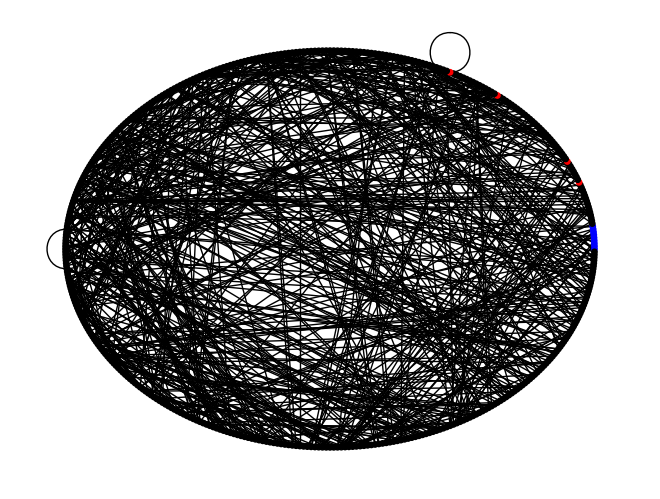

In [50]:
nx.draw(sample_wise_G['EC_E16BF_1_E']['graph'], \
        node_color = sample_wise_G['EC_E16BF_1_E']['color_map'], \
        pos=nx.circular_layout(sample_wise_G['EC_E16BF_1_E']['graph']), \
        node_size = 15)

In [103]:
def record_dist(labels_set):
    dist_list = []
    for ctg_1 in labels_set:
        for ctg_2 in labels_set:
            sid_1, sid_2 = ctg_1.split('_')[:-1], ctg_2.split('_')[:-1]
            if ctg_1 != ctg_2 and sid_1 == sid_2:
                try:
                    n=nx.shortest_path_length(G, source=ctg_1, target=ctg_2)
                    dist_list.append(n)
                except nx.NetworkXNoPath:
                    continue       
    return dist_list
    

In [104]:
pls_dist_list = record_dist(pls_labels_set)
chr_dist_list = record_dist(chr_labels_set)

In [169]:
print("Pairs of plasmid contigs connected to each other: ", len(pls_dist_list))
print("Pairs of chromosome contigs connected to each other: ", len(chr_dist_list))

Pairs of plasmid contigs connected to each other:  700
Pairs of chromosome contigs connected to each other:  2476


In [171]:
print("Average distance between two connected plasmid contigs: ", stat.mean(pls_dist_list))
print("Average distance between two connected chromosome contigs: ", stat.mean(chr_dist_list))

Average distance between two connected plasmid contigs:  8.211428571428572
Average distance between two connected chromosome contigs:  5.694668820678514


In [172]:
print("Minimum distance between two connected plasmid contigs: ", min(pls_dist_list))
print("Minimum distance between two connected chromosome contigs: ", min(chr_dist_list))

Minimum distance between two connected plasmid contigs:  1
Minimum distance between two connected chromosome contigs:  2


In [173]:
print("Maximum distance between two connected plasmid contigs: ", max(pls_dist_list))
print("Maximum distance between two connected chromosome contigs: ", max(chr_dist_list))

Maximum distance between two connected plasmid contigs:  35
Maximum distance between two connected chromosome contigs:  16


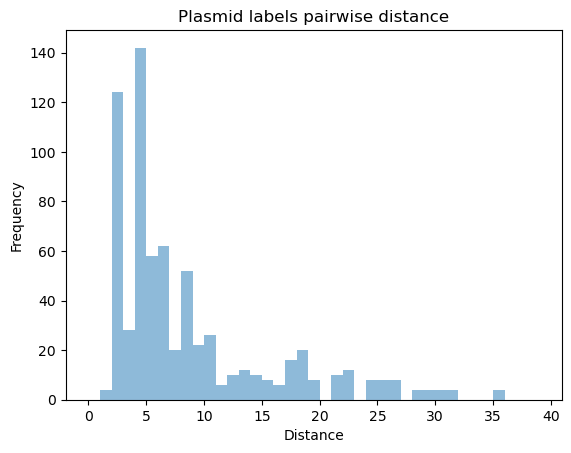

In [174]:
bins = np.arange(0,40,1)
plt.hist(pls_dist_list, bins=bins, alpha=0.5)
plt.title('Plasmid labels pairwise distance')
plt.xlabel('Distance')
plt.ylabel('Frequency')

plt.show()

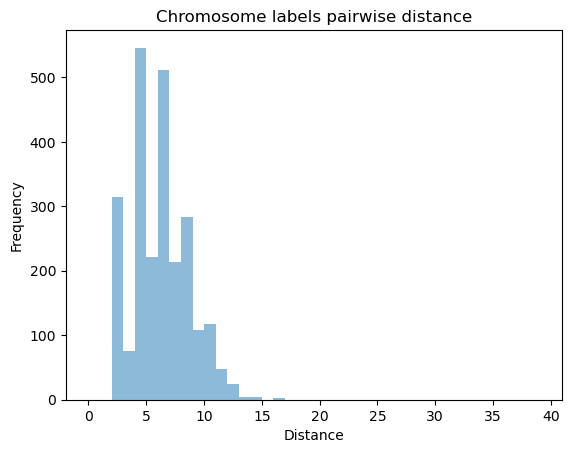

In [175]:
bins = np.arange(0,40,1)
plt.hist(chr_dist_list, bins=bins, alpha=0.5)
plt.title('Chromosome labels pairwise distance')
plt.xlabel('Distance')
plt.ylabel('Frequency')

plt.show()

We see that contigs with plasmid labels are on average further away than those with chromosome labels. Moreover, only 700 pairs of plasmid labelled contigs were connected at all. 

## Features for contigs with pseudolabels

Here, we take a look at the features for contigs with plasmid or chromosome pseudolabels. 

In [111]:
FEATURES_DIR = "../data/Ecoli_Features/"

In [146]:
df_list = []
length_list, cov_list = [], []
deg_list = []

degree_dict = {node:deg for (node, deg) in G.degree()}

for SID in os.listdir(FEATURES_DIR):
    features_file = FEATURES_DIR + SID + '/features.tsv'
    sample_df = pd.read_csv(features_file, sep='\t')
    sample_df['contig'] = SID + '_' + sample_df['contig'].astype(str)
    for index, row in sample_df.iterrows():
        length_list.append(ctg_dict[row['contig']]['length'])
        cov_list.append(ctg_dict[row['contig']]['depth'])
        deg_list.append(degree_dict[row['contig']])
    df_list.append(sample_df)
overall_df = pd.concat(df_list)
overall_df = overall_df.assign(length=length_list)
overall_df = overall_df.assign(degree=deg_list)

overall_df['plasmid'] = [1 if ctg in pls_labels_set else 0 for ctg in overall_df['contig']]

overall_df['chromosome'] = [1 if ctg in chr_labels_set else 0 for ctg in overall_df['contig']]

cols = overall_df.columns.tolist()
cols = cols[0:1] + cols[-2:] + cols[1:-2]
overall_df = overall_df[cols]

overall_df

,contig,plasmid,chromosome,plasforest_pls,plasforest_chr,plasgraph2_pls,plasgraph2_chr,platon_pls,platon_chr,rfplasmid_pls,rfplasmid_chr,length,degree
0,EC_E13DN_1_E_1,0,1,0,1,0.002880,0.998385,0,1,0.0,1.0,420557,2
1,EC_E13DN_1_E_2,0,1,0,1,0.004937,0.997082,0,1,0.0,1.0,321040,2
2,EC_E13DN_1_E_3,0,1,0,1,0.002322,0.998775,0,1,0.0,1.0,290906,2
3,EC_E13DN_1_E_4,0,1,0,1,0.003150,0.998164,0,1,0.0,1.0,284608,2
4,EC_E13DN_1_E_5,0,1,0,1,0.001870,0.998989,0,1,0.0,1.0,268593,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,EC_4957_C1_H_194,0,0,1,0,0.500000,0.500000,0,1,0.5,0.5,1,2
194,EC_4957_C1_H_195,0,0,0,1,0.500000,0.500000,0,1,0.5,0.5,1,2
195,EC_4957_C1_H_196,0,0,1,0,0.500000,0.500000,0,1,0.5,0.5,1,4
196,EC_4957_C1_H_197,0,0,1,0,0.500000,0.500000,0,1,0.5,0.5,1,2


In [147]:
pls_df = overall_df[overall_df['plasmid'] == 1]
chr_df = overall_df[overall_df['chromosome'] == 1]

In [148]:
pls_df

,contig,plasmid,chromosome,plasforest_pls,plasforest_chr,plasgraph2_pls,plasgraph2_chr,platon_pls,platon_chr,rfplasmid_pls,rfplasmid_chr,length,degree
34,EC_E13DN_1_E_35,1,0,1,0,0.022076,0.986211,1,0,0.996,0.004,38992,2
37,EC_E13DN_1_E_38,1,0,1,0,0.120354,0.918541,1,0,0.971,0.029,23307,2
47,EC_E13DN_1_E_48,1,0,1,0,0.102361,0.937483,1,0,0.658,0.342,12343,2
18,EC_0038_3S2_D_19,1,0,1,0,0.028226,0.981991,1,0,0.995,0.005,89983,2
31,EC_0038_3S2_D_32,1,0,1,0,0.110139,0.928455,1,0,0.972,0.028,23505,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,EC_0012_C1_H_77,1,0,0,1,0.999895,0.004028,1,0,0.884,0.116,5569,2
98,EC_0012_C1_H_99,1,0,0,1,0.999953,0.005581,0,1,0.626,0.374,2235,2
99,EC_0012_C1_H_100,1,0,0,1,0.999891,0.008542,1,0,0.968,0.032,2089,2
20,EC_4957_C1_H_21,1,0,1,0,0.009155,0.995040,1,0,1.000,0.000,79861,2


Length distribution of plasmid labelled contigs


<Axes: >

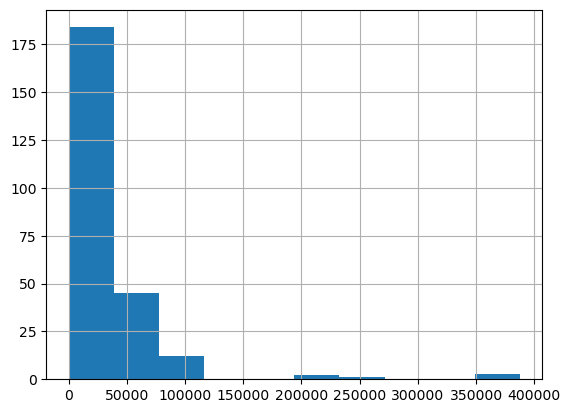

In [176]:
print("Length distribution of plasmid labelled contigs")
pls_df['length'].hist()

Length distribution of plasmid labelled contigs at most 150000 bp


<Axes: >

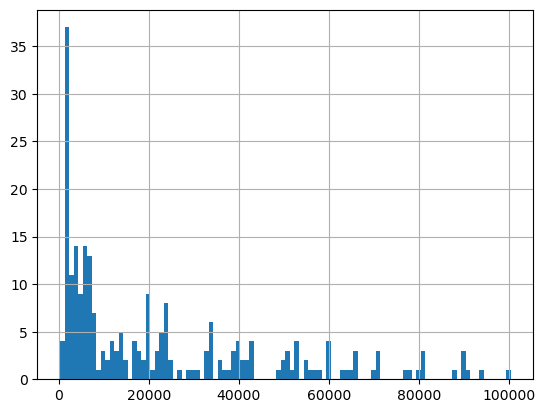

In [178]:
pls_df_short_150000 = pls_df[pls_df['length'] <= 150000]
print("Length distribution of plasmid labelled contigs at most 150000 bp")
pls_df_short_150000['length'].hist(bins=100)

In [151]:
pls_df_short_150000.shape[0]

241

Length distribution of plasmid labelled contigs at least 1000 bp


<Axes: >

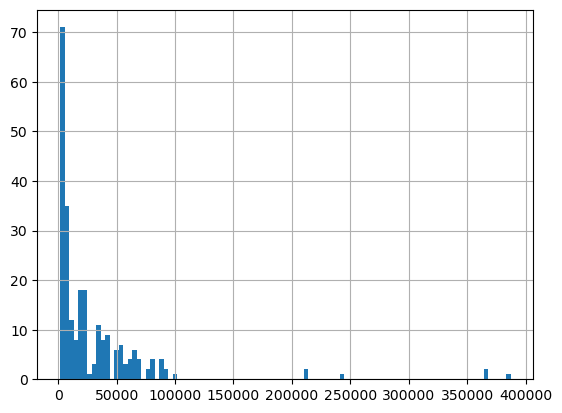

In [179]:
pls_df_long_1000 = pls_df[pls_df['length'] >= 1000]
print("Length distribution of plasmid labelled contigs at least 1000 bp")
pls_df_long_1000['length'].hist(bins=100)

In [153]:
pls_df_long_1000.shape[0]

243

Length distribution of plasmid labelled contigs at least 10000 bp


<Axes: >

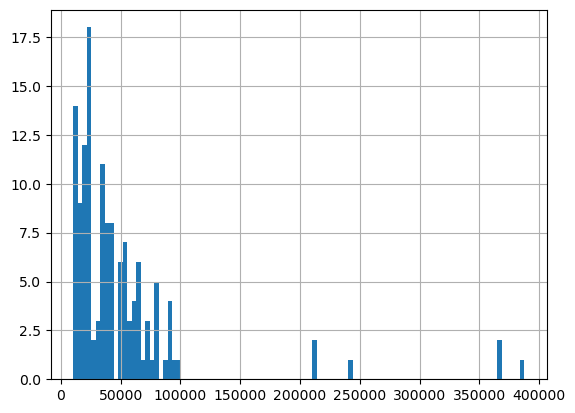

In [180]:
pls_df_long_10000 = pls_df[pls_df['length'] >= 10000]
print("Length distribution of plasmid labelled contigs at least 10000 bp")
pls_df_long_10000['length'].hist(bins=100)

In [155]:
pls_df_long_10000.shape[0]

134

Text(0.5, 1.0, 'Features for contigs with plasmid labels')

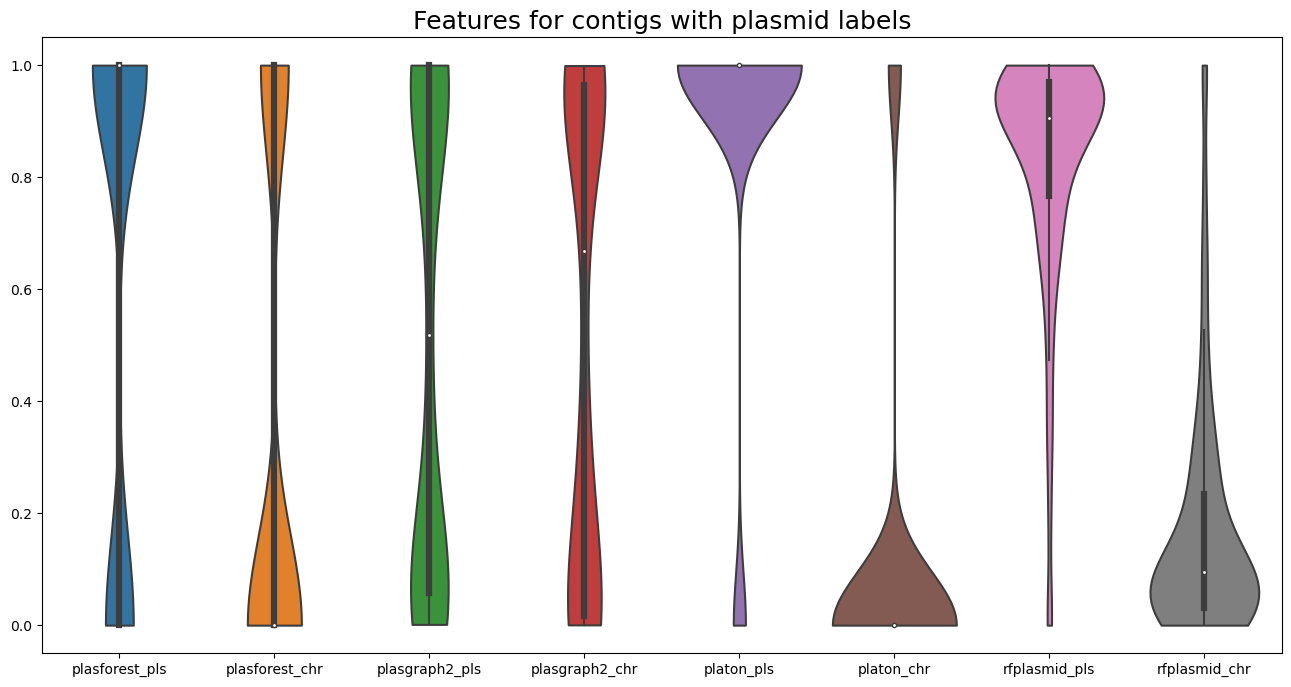

In [181]:
plt.figure(figsize=(16,8))
ax = sns.violinplot(data=pls_df[['plasforest_pls','plasforest_chr','plasgraph2_pls','plasgraph2_chr',\
                            'platon_pls','platon_chr','rfplasmid_pls','rfplasmid_chr']], cut=0)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
ax.set_title('Features for contigs with plasmid labels', fontsize=18) 

Text(0.5, 1.0, 'Features for contigs with plasmid labels (longer than 1000 bp)')

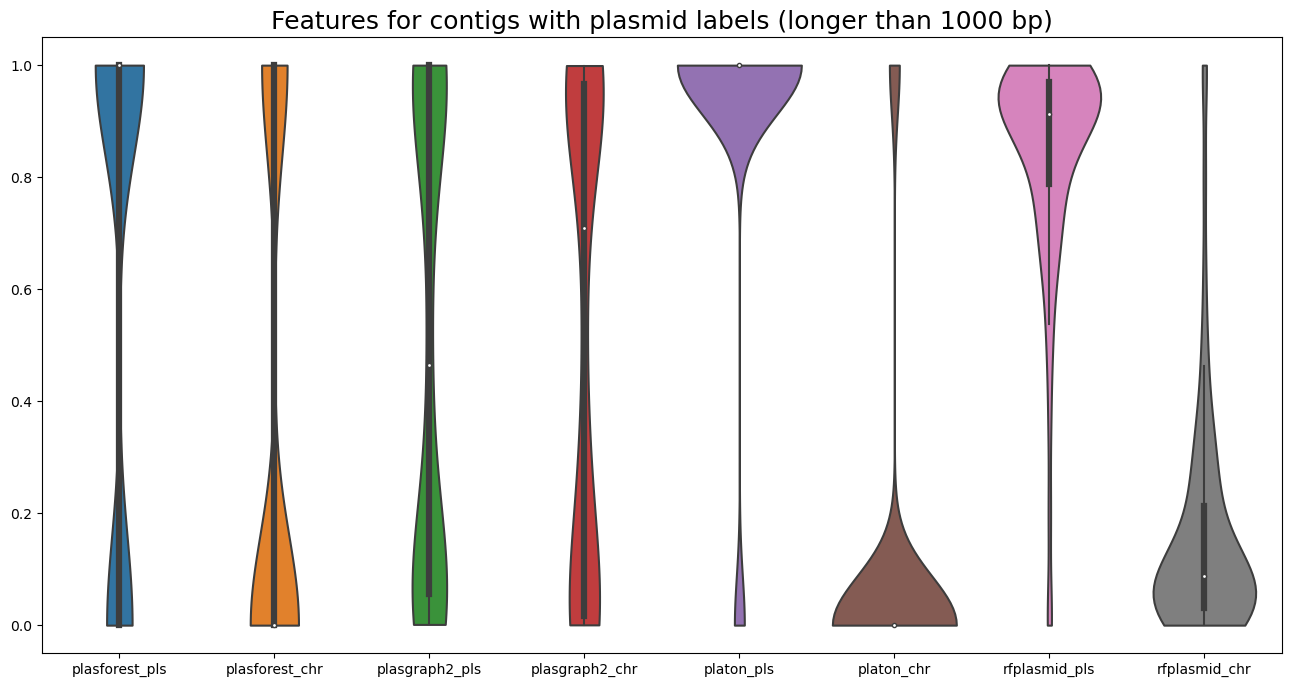

In [182]:
plt.figure(figsize=(16,8))
ax = sns.violinplot(data=pls_df_long_1000[['plasforest_pls','plasforest_chr','plasgraph2_pls','plasgraph2_chr',\
                            'platon_pls','platon_chr','rfplasmid_pls','rfplasmid_chr']], cut=0)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
ax.set_title('Features for contigs with plasmid labels (longer than 1000 bp)', fontsize=18) 

Text(0.5, 1.0, 'Features for contigs with plasmid labels (longer than 10000 bp)')

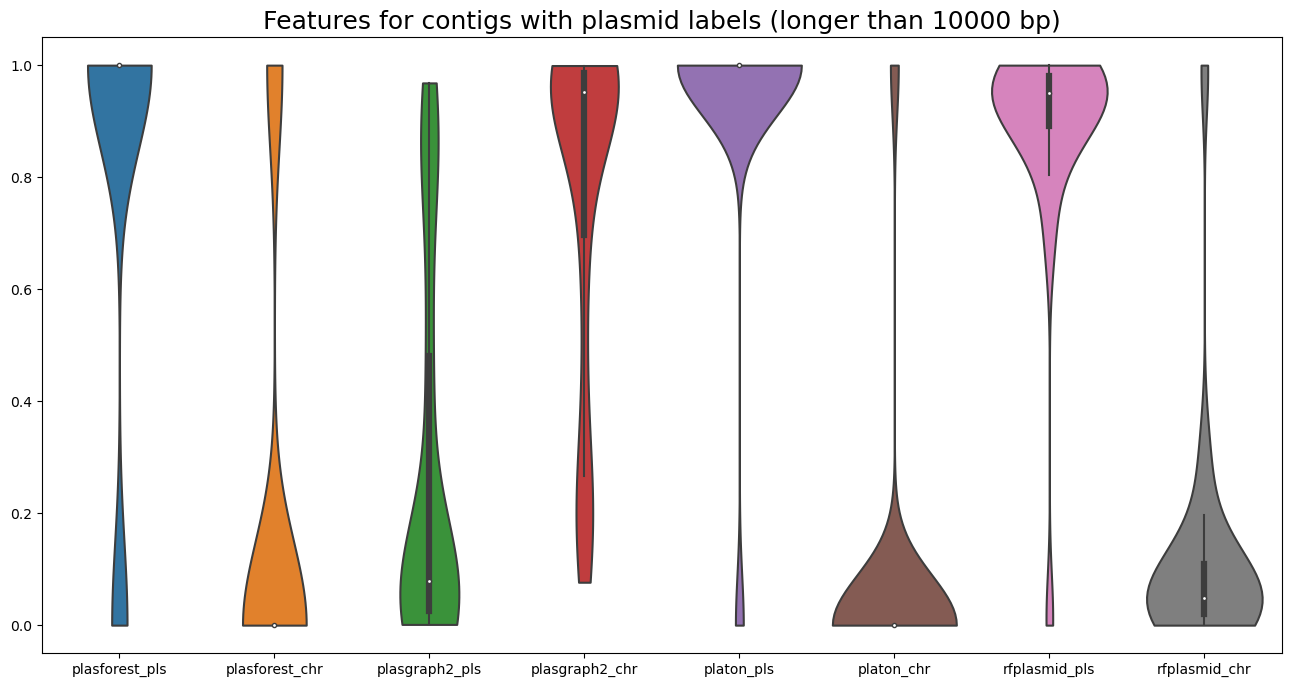

In [183]:
plt.figure(figsize=(16,8))
ax = sns.violinplot(data=pls_df_long_10000[['plasforest_pls','plasforest_chr','plasgraph2_pls','plasgraph2_chr',\
                            'platon_pls','platon_chr','rfplasmid_pls','rfplasmid_chr']], cut=0)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
ax.set_title('Features for contigs with plasmid labels (longer than 10000 bp)', fontsize=18) 

Text(0.5, 1.0, 'Features for contigs with chromosome labels')

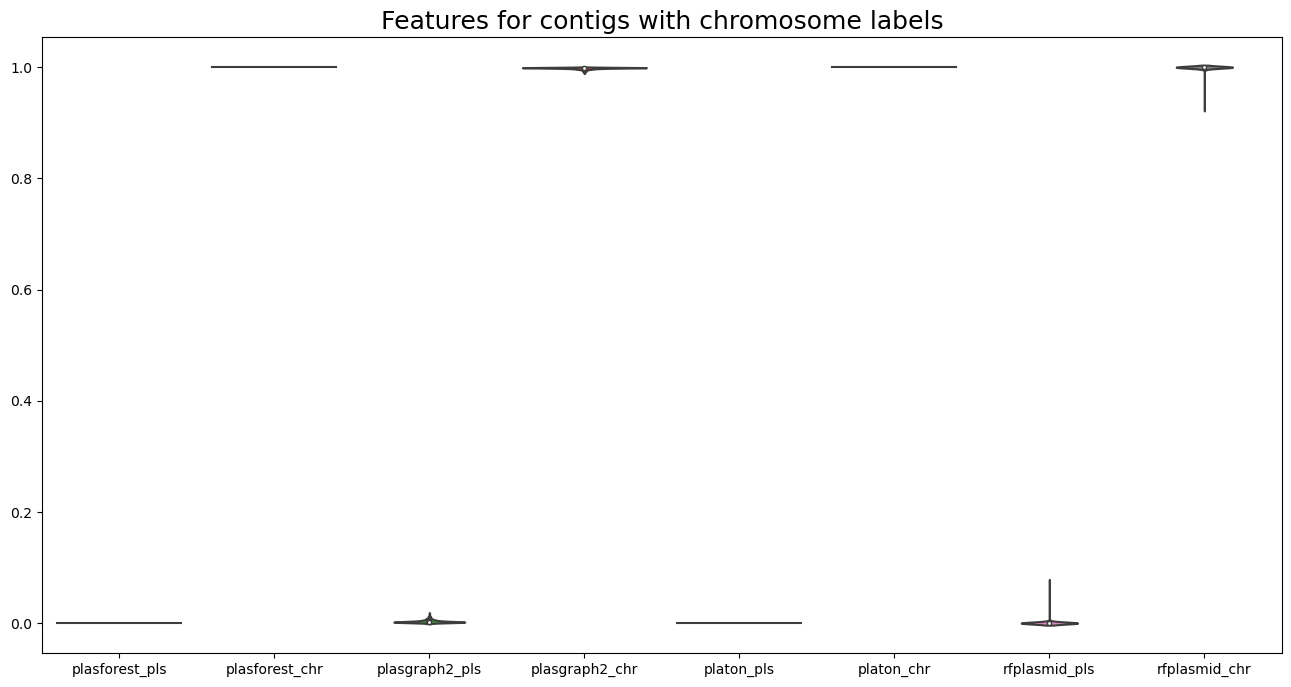

In [184]:
plt.figure(figsize=(16,8))
ax = sns.violinplot(data=chr_df[['plasforest_pls','plasforest_chr','plasgraph2_pls','plasgraph2_chr',\
                            'platon_pls','platon_chr','rfplasmid_pls','rfplasmid_chr']])
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
ax.set_title('Features for contigs with chromosome labels', fontsize=18) 

Here, we observe that the features from Platon and RFPlasmid tend to agree with the pseudolabels obtained from the BLAST mappings. For Plasforest and Plasgraph2, the features for shorter contigs seem to disagree with the pseudolabels. We see that contigs with plasmid labels do not always show a uniform trend (either towards a score of 0 or of 1), especially with Plasgraph2. 

When we consider only those plasmid labelled contigs above 10000 bp, we observe a relatively better scoring pattern. With the exception of Plasgraph2, we see that contigs have a high plasmid score and low chromosome score. Plasgraph2 shows the opposite pattern. However, for our purposes this still works because it is able to assign similar scores to plasmid labelled contigs.  

The features for chromosome labelled contigs agree with the chromosome pseudolabels; showing a low plasmid score and a high chromosome score. However, this then brings the scores of Plasgraph2 into question. Is it incorrectly classifying plasmid labelled contigs?

## Vertex degree

In [163]:
print('Min degree: ', overall_df['degree'].min())
print('Max degree: ', overall_df['degree'].max())
print('Mean degree: ', overall_df['degree'].mean())

Min degree:  1
Max degree:  38
Mean degree:  2.745069393718042


Degree distribution of all contigs


<Axes: >

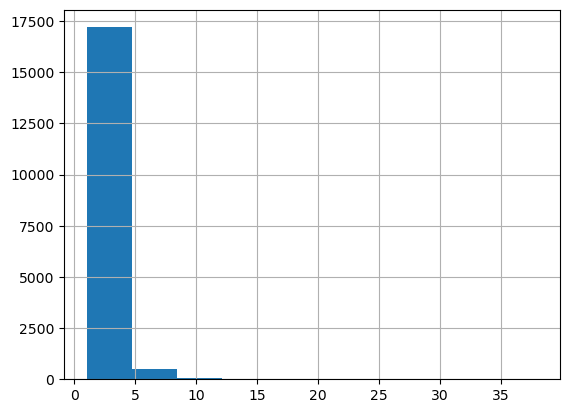

In [185]:
print("Degree distribution of all contigs")
overall_df['degree'].hist()

Degree distribution of plasmid labelled contigs


<Axes: >

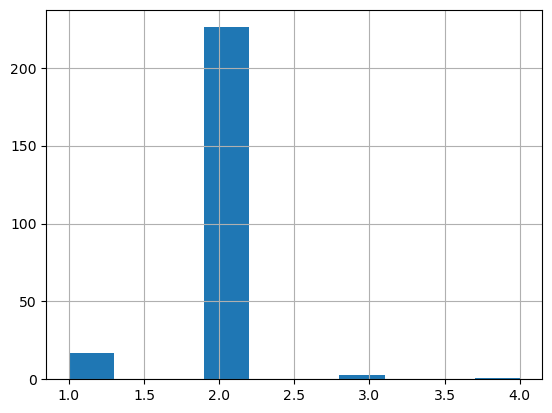

In [186]:
print("Degree distribution of plasmid labelled contigs")
pls_df['degree'].hist()

Degree distribution of chromosome labelled contigs


<Axes: >

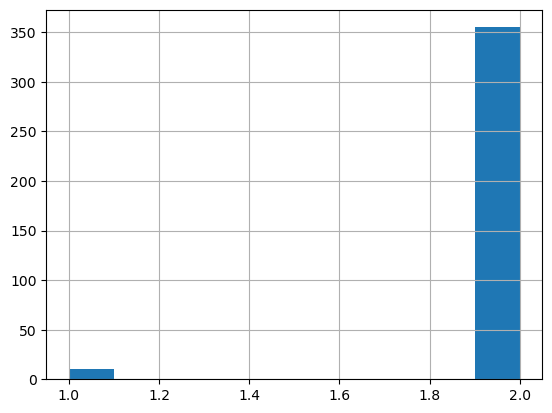

In [187]:
print("Degree distribution of chromosome labelled contigs")
chr_df['degree'].hist()

Most of the contigs, irrespective of labels have the degree 2. Note that here we have NOT accounted for the orientation (head and tail) of the contigs. However, this likely implies that most samples contain a high amount of vertices with degree 2. Ideally, we can assume that barring sequencing errors, contigs along a path should belong to the same molecule, whichever it be, plasmid or chromosome. Contigs along a path should be classified in the same set. 